## Something is not normal

This is probably the point where I should bring this up, but this is not the normal way that people generally go about teaching confidence intervals. 

Generally speaking people will walk down the road of old school inferential statistics and teach you confidence intervals using the Central Limit Theorem and Normal distributions. 

There are two reasons that I am not doing this:

1. This would require a lot more stats knowledge to fully understand and grasp
2. This is much less powerful than bootstrap confidence intervals and hypothesis tests

And for those reasons we are sticking with bootstrap tests. 

Let me make one final point here: there are sooo many ways to do the above! There are hundreds of ways that do better under one condition or another, so I have tried to optimize for versatility and simplicity when choosing the methods I show below. 

Before we continue, we need to look at the assumptions again, because WITHOUT THE ASSUMPTIONS WE CANNOT DO ANY OF THE BELOW!!!

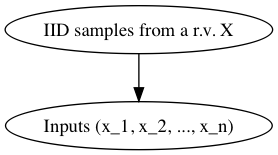

In [15]:
import networkx as nx
from nxpd import draw
from nxpd import nxpdParams
nxpdParams['show'] = 'ipynb'

G = nx.DiGraph()
G.add_node('IID samples from a r.v. X')
G.add_node('Inputs (x_1, x_2, ..., x_n)')
G.add_edge('IID samples from a r.v. X', 'Inputs (x_1, x_2, ..., x_n)')
draw(G)

## A Different question

Let's start off by asking a different question. Let's say we had a population, like the one below

In [16]:
import numpy as np

population_dist = np.random.poisson(30, size=1000)

population_dist[:5]

array([28, 21, 23, 29, 32])

And let's say you were taking samples from it 10 at a time and finding their mean. What would you expect the mean of the samples to be? What mean would be extraordinary? 

To be exact, I'm asking you for a range of possible means I should expect 99% of the time. How would you figure this out?

Your first instinct might be to construct and visualize the random variable representing sample means, I will do this below:

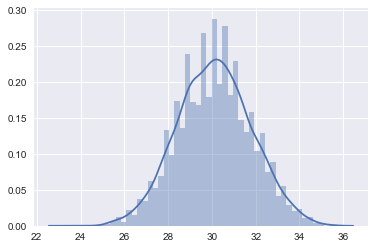

In [17]:
%matplotlib inline
import seaborn as sns

sampling_dist = [np.mean(np.random.choice(population_dist, 10, replace=False)) for _ in range(9999)]

sns.distplot(sampling_dist)

*Note that this distribution has a special name, the sampling distribution*

Okay now what would you say? Would getting a mean of 30 be unexpected? What about 36? What about 40? Obviously you can give me answers to the above, but they did not exactly answer my question. What would be a reasonable range?

One way that we can phrase this question is: how far from the actual mean do you expect your sample mean to be?

The actual mean of this guy is 30, so how far from 30 do you expect it to be? Well what fraction of samples above are more than 5 away from 30?

In [18]:
((np.array(sampling_dist) - 30)**2 > 25).mean()

0.0014001400140014001

It looks like there is less than a 1% chance that the sample mean is more than 5 away from the real mean of the population...

**Whoa**

What did we just say:

...there is less than a 1% chance that the sample mean is more than 5 away from the real mean of the population...

Do y'all see what we did. We just made an interval that we are 99% sure contains the real mean, aka the sample mean plus or minus 5. We just need to reverse the order of the statement to see it fully:

...there is less than a 1% chance that the real mean is more than 5 away from the sample mean of the population...

## Bootstrap Confidence Interval

So the question is how did we get there? Let me recap in a couple of steps:

1. We sampled from the distribution a ton of times to make a sampling distribution
2. We found the distance from the mean such that a sample would have a less than X% chance of being further

Basically we just made a complex function of the population distribution. If there were only a way to esitmate the answer to this function from the sample...

XD

You guessed it, this is another application of the plug in principle. This is formally called bootstrapping, let's have a look to see how it is done below:

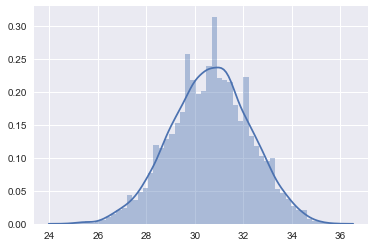

In [19]:
sample = np.random.choice(population_dist, 10, replace=False)

bootstrap_dist = [np.mean(np.random.choice(sample, 10, replace=True)) for _ in range(9999)]

sns.distplot(bootstrap_dist)

Next step we find the distance from the sample mean such that it would have less than an X% chance of being further:

In [20]:
sample_mean = np.mean(sample)
print sample_mean

((np.array(bootstrap_dist) - sample_mean)**2 > 25).mean()

30.6


0.0015001500150015

### Percentile Confidence Interval

Well I hope you are smiling now. When I first saw this it was like magic for me. It is simply an application of the plug in principle. For all this knowledge we had to learn just one thing. It almost feels like cheating!

There is one shortcut I am going to use throughout the class, and that will be the percentile confidence interval for bootstrap. It is a pretty simple change from what we do above. It makes one more assumption, that the bootstrap distribution is symetric (the long name for it is the bootstrap central limit theorum). 

But the concept is pretty simple.

Let's say you are looking for a 95% confidence interval. Simply take the bootstrap distribution that we made above, and trim off the 2.5% of the extremes on the right and the left, like so:

In [21]:
print np.percentile(bootstrap_dist, 2.5)
print np.percentile(bootstrap_dist, 97.5)

27.3
33.8


And that is the 95% confidence interval!

Seaborn even has nice visualizations of confidence intervals built in:

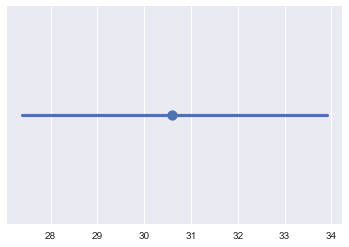

In [22]:
sns.pointplot(sample, ci=95)

As well as a simple function to do it for you:

In [23]:
bootstrap_dist = sns.algorithms.bootstrap(sample, n_boot=9999, func=np.mean)

print np.percentile(bootstrap_dist, 2.5)
print np.percentile(bootstrap_dist, 97.5)

27.3
33.8


Now before we move on I want to say something on the method we use here, and that is on the randomness. 

Where does the randomness come from?

We have a sampling distribution for our true population statistic. Does this mean that the true population statistic is random? 

No

What this means is that by taking RANDOM SAMPLES we get RANDOM ESTIMATES OF THE POPULATION STATISTIC. The population statistic stays the same.

So when we say that we are 95% confident that the true population statistic lies within these bounds that are generated via random sampling, what we mean is that 95% of the time we will sample such that the bounds contain the true population statistic. 

This is a crucial difference to understand, so feel free to go through this section twice.

## It get's smaller

We should mention again the tradeoff that we said when we first introduced the plug in principle: as we get bigger samples, the estimate gets better. We can see this quite visibly here. As we get more samples the confidence interval will decrease because we are more confident in what the true population parameter will be. We can visually see this here, check out the confidence intervals of different sizes of samples:

In [26]:
sample = np.random.choice(population_dist, 5, replace=False)

bootstrap_dist = sns.algorithms.bootstrap(sample, n_boot=9999, func=np.mean)

print 'Sample size is 5'
print np.percentile(bootstrap_dist, 2.5)
print np.percentile(bootstrap_dist, 97.5)

sample = np.random.choice(population_dist, 50, replace=False)

bootstrap_dist = sns.algorithms.bootstrap(sample, n_boot=9999, func=np.mean)

print 'Sample size is 50'
print np.percentile(bootstrap_dist, 2.5)
print np.percentile(bootstrap_dist, 97.5)

Sample size is 5
22.6
35.8
Sample size is 50
30.58
33.16


## Why this matters

Well hopefully you can see how this matters a ton! Any time you are curious about characteristics of a population based on data that you get from a sample, these techniques can help you ascertain reasonable bounds for that characteristic or falsify your assumptions.

What is most important to remember is that you can't just use these techniques willy nilly! You must satisfy the assumptions above, and only then will the techniques prove correct! 